In [ ]:
### Xi -> reference representation  Xj -> target representation
## adjust reference Xi  to  Xi' => CKA(Xi', Xj) ----> 1
# R -> min ||XjR - Xi'||

##### adjust : keep similar samples and highlight the diff samples' difference 
# step1: find diff samples and same samples
# step2: adjust diff samples or just keep the same set

In [14]:
#### 

import torch
import sys
sys.path.append("..")
from singleVis.data import NormalDataProvider








sys.path.append(REF_PATH)

REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

CLEAN_PATH = "/home/yifan/dataset/clean_ref/pairflip/cifar10/0"


from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)


tar_provider = NormalDataProvider(CLEAN_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)


Finish initialization...
Finish initialization...


In [103]:
ref_train_data = ref_provider.train_representation(200).squeeze()
tar_train_data = tar_provider.train_representation(200).squeeze()
ref_prediction = ref_provider.get_pred(200, ref_train_data)
tar_prediction = tar_provider.get_pred(200, tar_train_data)
ref_prediction_res = ref_prediction.argmax(axis=1)
tar_prediction_res = tar_prediction.argmax(axis=1)
### get confidence scores result
from scipy.special import softmax
import numpy as np
def get_conf(pred):
    scores = np.amax(softmax(pred, axis=1), axis=1)
    return scores
ref_scores = get_conf(ref_prediction)
tar_scores =  get_conf(tar_prediction)

100%|██████████| 250/250 [00:00<00:00, 9511.15it/s]


In [104]:
distance_high_indicates = []
low_indicates = []
def EMAE(Y, y, a=1.5):
    """
    param：
        Y: 原始序列（假定波动较大）
        y: 拟合序列（假定波动较小）
        a: 指数的自变量，≥1，该值越大，则两序列间的残差（特别是残差的离群值）对EMAE返回值影响的强化作用越明显；
        当a=1时，EMAE化简为MAE。
    return：
        指数MAE值，该值的大小与两条序列间平均偏差程度成正比，该值越大，平均偏差程度越大；
        且两序列间的残差（特别是残差的离群值）对EMAE的影响比MAE大。
    """

    Y, y = np.array(Y), np.array(y)
    Y[Y < 0] = 0  # 使指数的底数≥1，则所有指数均为递增函数
    y[y < 0] = 0
    emae = sum(abs((Y+1)**a - (y+1)**a)) / len(Y)

    return emae

for i in range(len(ref_prediction)):
    mes_val = EMAE(ref_prediction[i], tar_prediction[i])
    if mes_val > 1:
        distance_high_indicates.append(i)
    else:
        low_indicates.append(i)
#### 
diff_indicates = []
same_indicates = []
for i in range(len(ref_prediction)):
    if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in low_indicates):     
        same_indicates.append(i)
    else:
        diff_indicates.append(i)


In [105]:
#### same_set representation CKA
import numpy as np
from sklearn.cross_decomposition import CCA
# 建立模型
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]
cca = CCA(n_components=1)
# 训练数据
cca.fit(X, Y)
# print(X)
X_train_r, Y_train_r = cca.transform(X, Y)
# print(X_train_r)
print('referece epoch 200 vs target epoch 200')
print(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1]) #输出相关系数

referece epoch 200 vs target epoch 200
0.9999999999999974


In [106]:
len(same_indicates)

334

In [113]:

# Step2: Computing the loss 
def compute_loss(X, Y, R):
    '''
    Inputs: 
       X: a matrix of dimension (m,n) where the columns are the English embeddings.
       Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
       R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
       L: a matrix of dimension (m,n) - the value of the loss function for given X, Y and R.
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # m is the number of rows in X
    m = len(X)

    # diff is XR - Y
    diff = np.dot(X, R) - Y

    # diff_squared is the element-wise square of the difference
    diff_squared = diff**2

    # sum_diff_squared is the sum of the squared elements
    sum_diff_squared = diff_squared.sum()

    # loss is the sum_diff_squared divided by the number of examples (m)
    loss = sum_diff_squared/m
    ### END CODE HERE ###
    return loss
def compute_gradient(X, Y, R):
    '''
        the gradient of the loss with respect to the matrix encodes how much a tiny change 
    in some coordinate of that matrix affect the change of loss function.
        Gradient descent uses that information to iteratively change matrix R until we reach 
    a point where the loss is minimized.
    Inputs: 
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        R: a matrix of dimension (n,n) - transformation matrix from Y2d to X2d
    Outputs:
       g: a matrix of dimension (n,n) - gradient of the loss function L for given X, Y and R.
    '''
    # m is the number of rows in X
    m = len(X)

    rows, columns = X.shape

    gradient = (np.dot(X.T, np.dot(X, R) - Y) * 2)/rows
    assert gradient.shape == (columns, columns)
    ### END CODE HERE ###
    return gradient


# Most of the time we iterate for a fixed number of training steps rather than iterating until the loss falls below a threshold.

# 1.Calculate gradient g of the loss with respect to the matrix R. 
# 2. Update R (Rnew = Rold - αg) . α is the learning rate which is a scalar.

# alignment_embeddings
def align_embeddings(X: np.ndarray, Y: np.ndarray,
                      train_steps:int,
                      learning_rate: float=0.0003,
                      seed: int=129) -> np.ndarray:
    '''
    Finding the optimal R with gradient descent algorithm
    Inputs:
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||projector(X R) - projector ( Y )||^2
    '''
    # the number of columns in X is the number of dimensions for a word vector (e.g. 300)
    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    R = np.random.rand(X.shape[1], X.shape[1])
    # R = Variable(torch.ones(X.shape[1],X.shape[1]),requires_grad=True)

   

        
    train_steps = 50000
    for i in range(train_steps):
        if i%500 == 0:
            loss = compute_loss(X,Y,R)
            print(f"iteration {i}, loss {loss}") 



        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        # use the function that you defined to compute the gradient
        gradient = compute_gradient(X, Y, R)
       
        
         # update R by subtracting the learning rate times gradient
        R -= learning_rate * gradient
        ### END CODE HERE ###
    
    return R

# np.random.seed(129)
# m = 10
# n = 5
Y = ref_train_data[same_indicates]
X = tar_train_data[same_indicates]

# X_pred = exchange_provider.get_pred(200, ref_provider.train_representation(200))
# Y_pred = ref_provider.get_pred(200, ref_provider.train_representation(200))
S = align_embeddings(X, Y, 20000)

iteration 0, loss 29956395.26221284
iteration 500, loss 2528.4717214330663
iteration 1000, loss 1813.0987051358718
iteration 1500, loss 1419.8749366306733
iteration 2000, loss 1166.4568258895317
iteration 2500, loss 987.4784730483208
iteration 3000, loss 853.5061128210835
iteration 3500, loss 749.1551965383318
iteration 4000, loss 665.4928322110047
iteration 4500, loss 596.9219673682553
iteration 5000, loss 539.7303548371564
iteration 5500, loss 491.34552009313535
iteration 6000, loss 449.92185372698043
iteration 6500, loss 414.09742438910905
iteration 7000, loss 382.84353024592986
iteration 7500, loss 355.3677801600962
iteration 8000, loss 331.049508121991
iteration 8500, loss 309.3954772480555
iteration 9000, loss 290.0087369059287
iteration 9500, loss 272.5662499751101
iteration 10000, loss 256.8025134906765
iteration 10500, loss 242.49736500181513
iteration 11000, loss 229.4667691507295
iteration 11500, loss 217.5557630690957
iteration 12000, loss 206.63298997673854
iteration 12500

In [108]:
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]

# X_pred = exchange_provider.get_pred(200, ref_provider.train_representation(200))
# Y_pred = ref_provider.get_pred(200, ref_provider.train_representation(200))
R = align_embeddings(X, Y, 10000)

iteration 0, loss 29870255.034031108
iteration 500, loss 2522.627627797565
iteration 1000, loss 1813.0369867846919
iteration 1500, loss 1419.9153840110966
iteration 2000, loss 1165.8855719681276
iteration 2500, loss 986.2063590942396
iteration 3000, loss 851.6563411832147
iteration 3500, loss 746.8974119849779
iteration 4000, loss 662.9754397788506
iteration 4500, loss 594.2571474858188
iteration 5000, loss 536.998137014721
iteration 5500, loss 488.601710973188
iteration 6000, loss 447.20500555112875
iteration 6500, loss 411.43399191798727
iteration 7000, loss 380.25148257304045
iteration 7500, loss 352.859096656797
iteration 8000, loss 328.63190829567975
iteration 8500, loss 307.0736297931561
iteration 9000, loss 287.78511266566795
iteration 9500, loss 270.4417289206272
iteration 10000, loss 254.77682005162592
iteration 10500, loss 240.56938261228737
iteration 11000, loss 227.63476923787604
iteration 11500, loss 215.81757310489806


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 9262.96it/s]


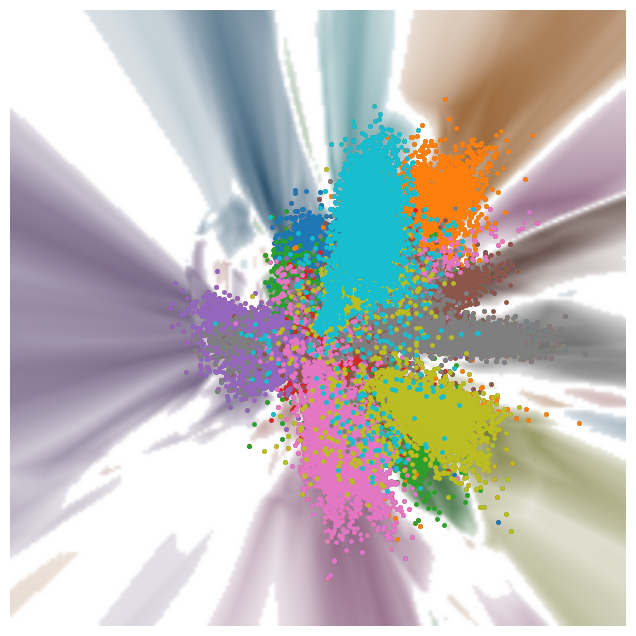

In [114]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
# ST = np.linalg.inv(S)
I = np.eye(512)
from representationTrans.trans_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, R,I, np.dot(tar_provider.train_representation(200),S), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
for i in range(len(diff_indicates)):
    tar_prediction_res[0]


In [72]:
len(same_indicates)

5

In [91]:
import numpy as np
from sklearn.cross_decomposition import CCA
# 建立模型
X = ref_train_data
Y = tar_train_data
cca = CCA(n_components=1)
# 训练数据
cca.fit(X, Y)
# print(X)
X_train_r, Y_train_r = cca.transform(X, Y)
# print(X_train_r)
print('referece epoch 200 vs current epoch 200')
print(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1]) #输出相关系数

referece epoch 200 vs current epoch 200
0.9764722451592688
